# Моделирование выходной температуры стали

Металлургический комбинат поставил задачу уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали на выходе из ковша.

### Описание этапа обработки стали

Этапы обработки стали:

- Сталь, залитую в металлический ковш, подогревают до нужной температуры графитовыми электродами.

- Для осуществления десульфации в сталь добавляют примеси. Легирование стали осуществляется или подачей кусков сплава из бункера для сыпучих материалов, или подачей проволоки.

- Перед легированием измеряют температуру стали и производят её химический анализ. Затем температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. После этого его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Обработка данных

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install -U seaborn
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)


In [2]:
df_arc = pd.read_csv('data_arc.csv')
df_bulk = pd.read_csv('data_bulk.csv')
df_bulk_time = pd.read_csv('data_bulk_time.csv')
df_gas = pd.read_csv('data_gas.csv')
df_temp = pd.read_csv('data_temp.csv')
df_wire = pd.read_csv('data_wire.csv')
df_wire_time = pd.read_csv('data_wire_time.csv')

Приведем названия столбцов к стандартному виду, данные с датами приведем к типу `datetime`:

In [3]:
df_arc.columns = ['key', 'start_heat', 'stop_heat', 'act_power', 'react_power']
df_arc['start_heat'] = pd.to_datetime(df_arc['start_heat'], format='%Y.%m.%d %H:%M:%S')
df_arc['stop_heat'] = pd.to_datetime(df_arc['stop_heat'], format='%Y.%m.%d %H:%M:%S')

Добавим столбец, содержащий информацию о продолжительности нагрева стали в секундах, а также полную мощность, вычисляющуюся по теореме Пифагора через активную и реактивную мощности (у этих величин сдвиг фаз на $\pi / 2$). Подробнее можно прочитать на [wikipedia](https://ru.wikipedia.org/wiki/Электрическая_мощность).

In [4]:
df_arc['duration'] = (df_arc['stop_heat'] - df_arc['start_heat']).dt.seconds
df_arc['full_power'] = (df_arc['act_power'] ** 2 + df_arc['react_power'] ** 2) ** .5
df_arc.info()
df_arc.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 7 columns):
key            14876 non-null int64
start_heat     14876 non-null datetime64[ns]
stop_heat      14876 non-null datetime64[ns]
act_power      14876 non-null float64
react_power    14876 non-null float64
duration       14876 non-null int64
full_power     14876 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 813.7 KB


,key,start_heat,stop_heat,act_power,react_power,duration,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,137,0.521549
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,338,1.574162
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,126,0.577638
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,210,0.975867
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,280,1.256527


По условиям задачи строки с одинаковыми ключами соответствуют разным итерациям одной партии. Их предлагается аггрегировать:

In [5]:
df_arc_grouped = df_arc.groupby('key').agg({'duration': 'sum', 'full_power': 'sum', 'act_power': 'sum'})
df_arc_grouped.head()

,duration,full_power,act_power
key,,,
1,1098,5.826395,4.878147
2,811,3.649216,3.052598
3,655,2.989534,2.525882
4,741,3.814962,3.209250
5,869,4.035758,3.347173


Объединим таблицы `df_bulk` и `df_bulk_time` в одну (объединяем по столбцу `key`, убедившись, что все значения уникальные), также приведем названия столбцов к нормальной форме. Тоже самое сделаем для таблиц `df_wire` и `df_wire_time`:

In [6]:
df_bulk.info()
df_bulk_time.info()

df_bulk_merged = df_bulk.merge(df_bulk_time, left_on='key', right_on='key', suffixes=(None, '_time'))
df_bulk_merged.columns = map(str.lower, df_bulk_merged.columns.str.replace(' ', ''))

df_bulk_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7 

,key,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,...,bulk6_time,bulk7_time,bulk8_time,bulk9_time,bulk10_time,bulk11_time,bulk12_time,bulk13_time,bulk14_time,bulk15_time
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [7]:
df_wire.info()
df_wire_time.info()

df_wire_merged = df_wire.merge(df_wire_time, left_on='key', right_on='key', suffixes=(None, '_time'))
df_wire_merged.columns = map(str.lower, df_wire_merged.columns.str.replace(' ', ''))
df_wire_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,wire1,wire2,wire3,wire4,wire5,wire6,wire7,wire8,wire9,wire1_time,wire2_time,wire3_time,wire4_time,wire5_time,wire6_time,wire7_time,wire8_time,wire9_time
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Таблица с информацией о количество подававшегося газа (уже агрегировано по партиям):

In [8]:
df_gas.columns = ['key', 'gas']
df_gas.info()
df_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key    3239 non-null int64
gas    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


По информации, полученной с консультации, первое измерение температуры (температура на входе) может быть использовано как признак для прогноза алгоритма, последнее измерение температуры - целевой признак. Промежуточные измерения температуры можно не учитывать.

In [9]:
df_temp.columns = ['key', 'meas_time', 'temp']
df_temp.info()
df_temp.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key          15907 non-null int64
meas_time    15907 non-null object
temp         13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,meas_time,temp
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


In [10]:
list_temp = []

for k in df_temp['key'].unique():
    df_k = df_temp[df_temp['key'] == k]
    if len(df_k) >= 2 and not df_k.iloc[0].isna()['temp'] and not df_k.iloc[-1].isna()['temp']:
        list_temp.append([df_k.iloc[0]['key'].astype(int),
                          df_k.iloc[-1]['temp'],
                          df_k.iloc[0]['meas_time'],
                          df_k.iloc[0]['temp']])

df_temp_key = pd.DataFrame(list_temp, columns=['key', 'target', 'meas_time', 'temp'])
df_temp_key['meas_time'] = pd.to_datetime(df_temp_key['meas_time'], format='%Y.%m.%d %H:%M:%S')
df_temp_key.info()
df_temp_key.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 4 columns):
key          2475 non-null int64
target       2475 non-null float64
meas_time    2475 non-null datetime64[ns]
temp         2475 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 77.5 KB


,key,target,meas_time,temp
0,1,1613.0,2019-05-03 11:16:18,1571.0
1,2,1602.0,2019-05-03 11:37:27,1581.0
2,3,1599.0,2019-05-03 12:13:17,1596.0
3,4,1625.0,2019-05-03 12:52:57,1601.0
4,5,1602.0,2019-05-03 13:23:19,1576.0


In [11]:
df = df_temp_key.merge(df_arc_grouped, left_on='key', right_on='key'
                 ).merge(df_bulk_merged, how='left', left_on='key', right_on='key'
                        ).merge(df_wire_merged, how='left', left_on='key', right_on='key'
                               ).merge(df_gas, how='left', left_on='key', right_on='key')

По информации, полученной на разборе задачи, известно, что пропущенные значения в таблицах `df_bulk`, `df_bulk_time`, `df_wire` и `df_wire_time` соответствуют прогонам, в которых соответствующий сыпучий или проволочный материал в ковш не добавлялись. Заменим пропущенные значения нулями.

In [12]:
df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 56 columns):
key            2475 non-null int64
target         2475 non-null float64
meas_time      2475 non-null datetime64[ns]
temp           2475 non-null float64
duration       2475 non-null int64
full_power     2475 non-null float64
act_power      2475 non-null float64
bulk1          2475 non-null float64
bulk2          2475 non-null float64
bulk3          2475 non-null float64
bulk4          2475 non-null float64
bulk5          2475 non-null float64
bulk6          2475 non-null float64
bulk7          2475 non-null float64
bulk8          2475 non-null float64
bulk9          2475 non-null float64
bulk10         2475 non-null float64
bulk11         2475 non-null float64
bulk12         2475 non-null float64
bulk13         2475 non-null float64
bulk14         2475 non-null float64
bulk15         2475 non-null float64
bulk1_time     2475 non-null object
bulk2_time     2475 non-null object
bulk

Стобцы c суффиксом в названии `_time` содержат информацию о времени подачи добавки в ковш.

### Исследовательский анализ данных

Представленные данные собраны в течение 120 дней:

In [13]:
df_arc['start_heat'].max() - df_arc['stop_heat'].min()

Timedelta('120 days 17:28:45')

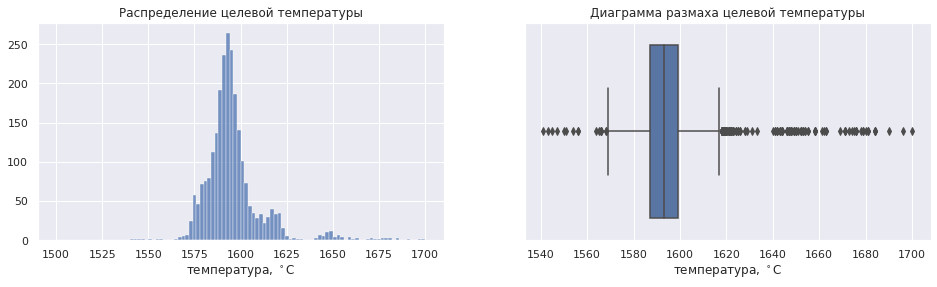

In [14]:
sns.set()
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(16,4))

sns.histplot(x=df['target'], bins=100, binrange=(1500,1700), ax=axes[0])
axes[0].set_title('Распределение целевой температуры')
axes[0].set_xlabel('температура, $^\circ$C')
axes[0].set_ylabel('')

sns.boxplot(x=df['target'], ax=axes[1])
axes[1].set_title('Диаграмма размаха целевой температуры')
axes[1].set_xlabel('температура, $^\circ$C')
axes[1].set_ylabel('')
plt.show()

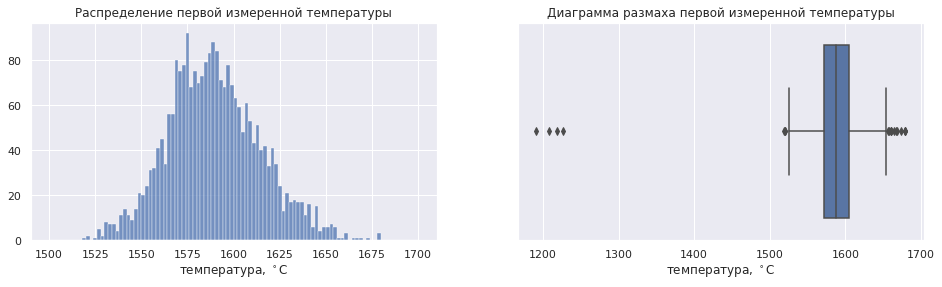

In [15]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(16,4))

sns.histplot(x=df['temp'], bins=100, binrange=(1500,1700), ax=axes[0])
axes[0].set_title('Распределение первой измеренной температуры')
axes[0].set_xlabel('температура, $^\circ$C')
axes[0].set_ylabel('')

sns.boxplot(x=df['temp'], ax=axes[1])
axes[1].set_title('Диаграмма размаха первой измеренной температуры')
axes[1].set_xlabel('температура, $^\circ$C')
axes[1].set_ylabel('')
plt.show()

Будем считать, что адекватные значения температуры находятся в диапазоне от 1500 до 1700 градусов Цельсия. Измерения, лежащие снаружи этого диапазона позже удалим.

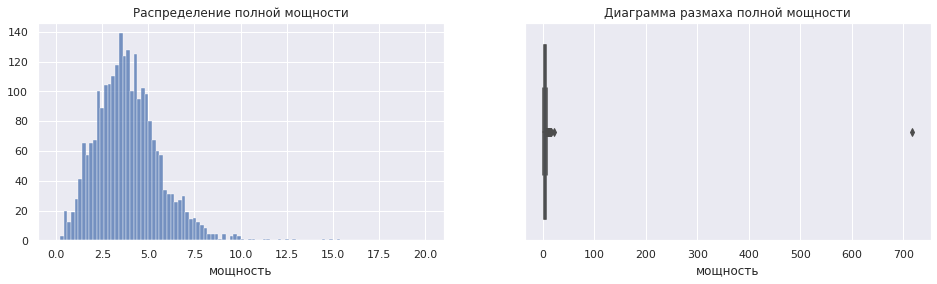

In [16]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(16,4))

sns.histplot(x=df['full_power'], bins=100, binrange=(0,20), ax=axes[0])
axes[0].set_title('Распределение полной мощности')
axes[0].set_xlabel('мощность')
axes[0].set_ylabel('')

sns.boxplot(x=df['full_power'], ax=axes[1])
axes[1].set_title('Диаграмма размаха полной мощности')
axes[1].set_xlabel('мощность')
axes[1].set_ylabel('')
plt.show()

Будем считать, что полная мощность находится в диапазоне от 0 до 20. На диаграмме размаха виден явный выброс. Такие значения позже удалим.

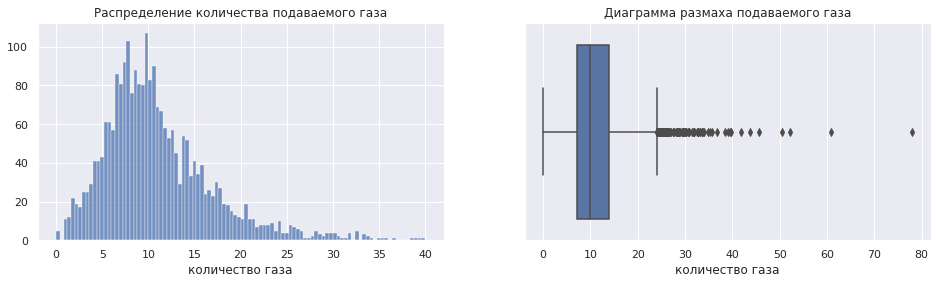

In [17]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(16,4))

sns.histplot(x=df['gas'], bins=100, binrange=(0,40), ax=axes[0])
axes[0].set_title('Распределение количества подаваемого газа')
axes[0].set_xlabel('количество газа')
axes[0].set_ylabel('')

sns.boxplot(x=df['gas'], ax=axes[1])
axes[1].set_title('Диаграмма размаха подаваемого газа')
axes[1].set_xlabel('количество газа')
axes[1].set_ylabel('')
plt.show()

Количество подаваемого газа возьмем от 0 до 50. Все иные значения будем предполагать выбросами и позже удалим:

In [18]:
df_clear = df.query('1500 <= target <= 1800 and 1500 <= temp <= 1800 and 0 <= full_power <= 20 and 0 <= gas <= 50')
df_clear.shape

(2465, 56)

### Моделирование

По полученной информации, в реальном процессе время добавки в сплав сыпучих и проволочных материалов неизвестно. Поэтому соответствующие признаки использовать в модели некорректно. Удалим их, а также признак `wire5` (он содержал лишь один ненулевой элемент). Кроме того проверим признаки на мультиколлинеарность:

In [19]:
unnecessary_columns = ['meas_time', 'bulk1_time', 'bulk2_time', 'bulk3_time', 'bulk4_time', 'bulk5_time', 'bulk6_time', 'bulk7_time',
                'bulk8_time', 'bulk9_time', 'bulk10_time', 'bulk11_time', 'bulk12_time', 'bulk13_time', 'bulk14_time',
                'bulk15_time', 'wire1_time', 'wire2_time', 'wire3_time', 'wire4_time', 'wire5_time', 'wire6_time',
                'wire7_time', 'wire8_time', 'wire9_time', 'wire5']

print('Список коррелирующих признаков:')
for column1 in df.drop('target', axis=1).drop(unnecessary_columns, axis=1).columns:
    for column2 in df.drop('target', axis=1).drop(unnecessary_columns, axis=1).columns:
        if column1 != column2 and df[column1].corr(df[column2]) > .8:
            print(column1, column2)

Список коррелирующих признаков:
duration act_power
act_power duration
bulk9 wire8
wire8 bulk9


В силу мультиколлинеарности признаки `duration` и `bulk9` далее удалим:

In [20]:
unnecessary_columns = ['meas_time', 'bulk1_time', 'bulk2_time', 'bulk3_time', 'bulk4_time', 'bulk5_time', 'bulk6_time', 'bulk7_time',
                'bulk8_time', 'bulk9_time', 'bulk10_time', 'bulk11_time', 'bulk12_time', 'bulk13_time', 'bulk14_time',
                'bulk15_time', 'wire1_time', 'wire2_time', 'wire3_time', 'wire4_time', 'wire5_time', 'wire6_time',
                'wire7_time', 'wire8_time', 'wire9_time', 'wire5', 'duration', 'bulk9']

features = df.drop('target', axis=1).drop(unnecessary_columns, axis=1)
target = df['target']

features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=.25, random_state=12345)
    
print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)

Размер обучающей выборки: (1856, 27)
Размер валидационной выборки: (619, 27)


In [21]:
model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_valid)

print('MAE для модели линейной регрессии: {:.2f}'.format(mean_absolute_error(target_valid, predict)))

MAE для модели линейной регрессии: 8.25


In [22]:
model = GridSearchCV(RandomForestRegressor(random_state=12345), scoring='neg_mean_absolute_error', cv=5,
                                     param_grid={'max_depth': range(2,10), 'n_estimators': range(2,10)})

model.fit(features_train, target_train)
predict = model.predict(features_valid)

print('MAE на валидационной выборке для модели случайного леса: {:.2f}'.format(mean_absolute_error(target_valid, predict)))
print('Наилучшие гиперпараметры модели случайного леса:', model.best_params_)

MAE на валидационной выборке для модели случайного леса: 6.68
Наилучшие гиперпараметры модели случайного леса: {'max_depth': 9, 'n_estimators': 9}


In [23]:
#GridSearchCV позволяет найти наилучшие гиперпарметры модели
#model = GridSearchCV(CatBoostRegressor(verbose=100, iterations=200, random_state=12345), scoring='neg_mean_absolute_error', cv=5,
#                                     param_grid={'learning_rate': np.arange(.05,.2,.01),
#                                                 'depth': range(2,8,1)})

model = CatBoostRegressor(verbose=False, max_depth=5, learning_rate=.035, l2_leaf_reg=.25, model_size_reg=.3,
                          iterations=700, random_state=12345)

model.fit(features_train, target_train)
predict = model.predict(features_valid)

print('MAE на валидационной выборке для модели CatBoost: {:.2f}'.format(mean_absolute_error(target_valid, predict)))
#print('Наилучшие гиперпараметры модели CatBoost:', model.best_params_)

MAE на валидационной выборке для модели CatBoost: 6.13


In [24]:
#model = GridSearchCV(XGBRegressor(objective ='reg:squarederror', random_state=12345), scoring='neg_mean_absolute_error', cv=5,
#                                     param_grid={'learning_rate': np.arange(.01, .1, .01),
#                                                 'max_depth': range(4,8)})

model = XGBRegressor(objective ='reg:squarederror', learning_rate=.036, colsample_bytree = .69, n_estimators = 800,
                     gamma = .33)

model.fit(features_train, target_train)
predict = model.predict(features_valid)

print('MAE на валидационной выборке для модели XGBoost: {:.2f}'.format(mean_absolute_error(target_valid, predict)))
#print('Наилучшие гиперпараметры модели XGBoost:', model.best_params_)

MAE на валидационной выборке для модели XGBoost: 5.98


Наименьшее значение MAE дает алгоритм XGBoost. На валидационной выборке значение составило 5.98 градуса. Посмотрим, какие признаки играют в оценке алгоритма наибольшую роль:

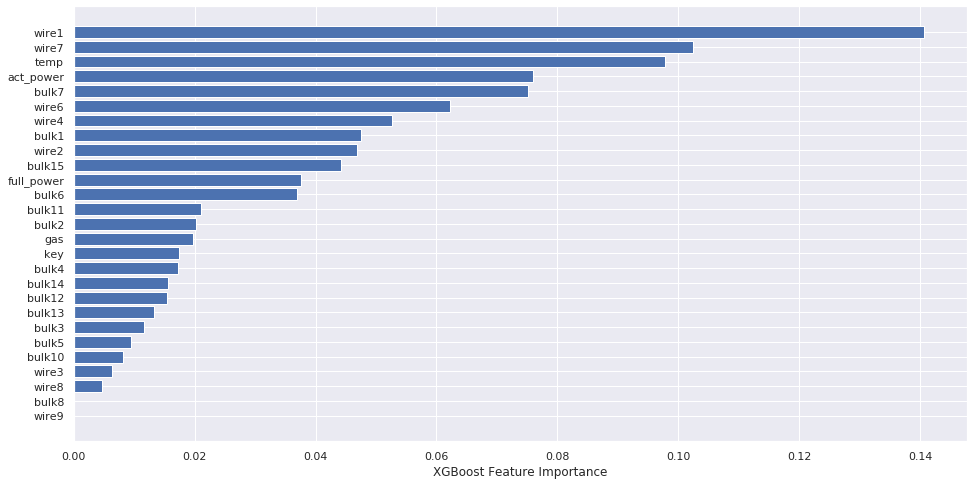

In [25]:
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(16,8))
plt.barh(features_valid.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.show()